In [1]:
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt
from mnist import MNIST
from utils import show_image
from sklearn import metrics

# 1 - Lendo o dataset

In [2]:
mnist = MNIST('datasets/mnist')
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

shape = (28,28)

# 2 - Criando as variáveis dos Pesos (`w`) e Bias (`b`) da Rede

In [49]:
input_size = shape[0]*shape[1]

layers_size = [
    100,
    75,
    50,
    25
]

output_size = 10

w = {
    'w1':tf.Variable(tf.random_normal([input_size, layers_size[0]])),
    'w2':tf.Variable(tf.random_normal([layers_size[0], layers_size[1]])),
    'w3':tf.Variable(tf.random_normal([layers_size[1], layers_size[2]])),
    'w4':tf.Variable(tf.random_normal([layers_size[2], layers_size[3]])),
    'wo':tf.Variable(tf.random_normal([layers_size[3], output_size])),

}

b = {
    'b1': tf.Variable(tf.random_normal([layers_size[0]])),
    'b2': tf.Variable(tf.random_normal([layers_size[1]])),
    'b3': tf.Variable(tf.random_normal([layers_size[2]])),
    'b4': tf.Variable(tf.random_normal([layers_size[3]])),
    'bo': tf.Variable(tf.random_normal([output_size])),

}

# 3 - Criando a Rede

In [50]:
def nn(input_x):
    
    w_keys = sorted(w.keys())
    b_keys = sorted(b.keys())

    wb_keys = zip(w_keys,b_keys)
    
    h_layers = {
        wb_keys[0]: tf.nn.relu(tf.add(tf.matmul(input_x,w['w1']),b['b1']))
    }
        
    
    for wb_key in wb_keys[1:-1]:
        last_layes_index = wb_keys.index(wb_key) - 1
        last_layes = h_layers[wb_keys[last_layes_index]]
        
        actual_layer_w = wb_key[0]
        actual_layer_b = wb_key[1]

        
        h_layers[wb_key] = tf.nn.relu(
            tf.add(
                tf.matmul(
                    last_layes,
                    w[actual_layer_w]),
                b[actual_layer_b]))
    
    last_layes = h_layers[wb_keys[last_layes_index+1]]
    output = tf.nn.softmax(tf.add(tf.matmul(last_layes,w['wo']),b['bo']))
    return output

# 4 - Formatando os Labels

$5 \rightarrow [0,0,0,0,0,1,0,0,0,0]$

$2 \rightarrow [0,0,1,0,0,0,0,0,0,0]$

In [51]:
np_test_images = np.matrix(test_images, dtype=np.float32)

np_train_labels = np.zeros((len(train_labels),10), dtype=np.float32)
for i in range(len(train_labels)):
    np_train_labels[i,train_labels[i]]=1

np_test_labels = np.zeros((len(test_labels),10), dtype=np.int)
for i in range(len(test_labels)):
    np_test_labels[i,test_labels[i]]=1

# 5 - Criando os Placeholders para input e Variáveis auxiliares

In [43]:
n_batchs = 3

total_size = len(train_labels)
batch_size = int(total_size/n_batchs)


init = tf.global_variables_initializer()
train_x = tf.placeholder(shape=(batch_size,input_size),dtype=tf.float32, name='input_x')
train_y = tf.placeholder(shape=(batch_size,output_size),dtype=tf.int32, name='input_y')

test_x = tf.constant(np_test_images,name='test_x')
test_y = tf.constant(test_labels.tolist(), name='test_y', dtype=tf.int64)

predict_train = nn(train_x)
predict_test = tf.argmax(nn(test_x), axis=1)

In [44]:
loss_op = tf.losses.mean_squared_error(train_y,predict_train)

adam = tf.train.AdamOptimizer(learning_rate=0.005)
adam_optimization = adam.minimize(
                loss_op,
                var_list = w.values()+b.values()
            )

In [45]:
init_op_g = tf.global_variables_initializer()
init_op_l = tf.local_variables_initializer()

loss_mean_vector = []
acc_vector = []

acc_op = tf.contrib.metrics.accuracy(
    predict_test,
    test_y
)

In [46]:
def get_batch_range(batch_i,batch_size,total_size):
    i = batch_size*batch_i
    f = i + batch_size
    if f > total_size:
        f = total_size
    return i,f

In [47]:
saver = tf.train.Saver()

In [48]:
with tf.Session() as sess:
    sess.run(init_op_g)
    sess.run(init_op_l)

    
    for i in range(1000):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)
        loss_vec = []
        for j in range(n_batchs):            
            inicio,fim = get_batch_range(
                j,
                batch_size,
                total_size
            )   
            
            sess.run(adam_optimization, feed_dict={
                train_x:train_images[inicio:fim],
                train_y:np_train_labels[inicio:fim]
            })
            
            l = sess.run(loss_op,
                         feed_dict={
                             train_x:train_images[inicio:fim],
                             train_y:np_train_labels[inicio:fim]})
            
            
            loss_vec.append(l)
            
            
        acc_value = sess.run(acc_op)

        acc_vector.append(acc_value)
        loss_mean_vector.append(np.mean(loss_vec))
        
        if(acc_value >= 0.8):
            save_path = saver.save(sess, "model_nn/model.ckpt")
            print("Model saved in path: %s" % save_path)
            break
                
            
        print("LOSS: %s"%(str(loss_mean_vector[-1])))
        print("ACC: %s"%(acc_value)) 
    
    save_path = saver.save(sess, "model_nn/model.ckpt")
    print("Model saved in path: %s" % save_path)

========== EPOCH 0 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 1 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 2 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 3 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 4 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 5 ==========
LOSS: 0.18156666
ACC: 0.0958
========== EPOCH 6 ==========


KeyboardInterrupt: 

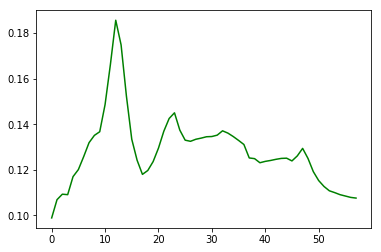

In [39]:
plt.plot(acc_vector, 'g-')
plt.show()